# Demo: Building Denoising Autoencoders in Pytorch (MNIST)

Adapted from: https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb

By: Jacob Cybulski<br>
Date: July 2023<br>
Comment: *Lots of bugs fixed, works with Torch 2, on both CPU and GPU*

Adapted From: Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium)<br>
Date: Jun 28, 2021

In [1]:
!pip list | grep torch

torch                         2.0.1+cu118
torchaudio                    2.0.2+cu118
torchsummary                  1.5.1
torchvision                   0.15.2+cu118


In [2]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from sklearn.manifold import TSNE

## Prelims: Get data and create tensor data loaders

In [3]:
data_dir = '../dataset'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

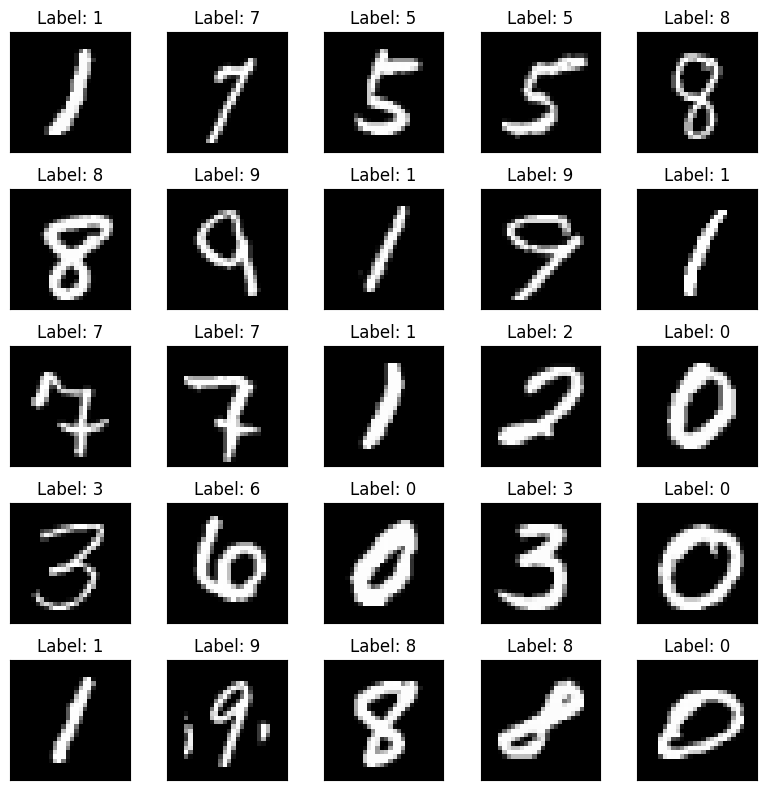

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

In [6]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1 Define Encoder and Decoder classes

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        
        # Apply convolutions
        x = self.encoder_cnn(x)
        
        # Flatten
        x = self.flatten(x)
        
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        
        # Apply linear layers
        x = self.decoder_lin(x)
        
        # Unflatten
        x = self.unflatten(x)
        
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## 2 initialize models, loss and optimizer
*Note that "d" is the size of a latent space*

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

In [10]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
print(encoder)
print(decoder)

Selected device: cuda
Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTr

## 3 Train model

In [11]:
im = test_dataset[0][0].unsqueeze(0)
a = im + torch.randn_like(im)*0.3
print(a)

tensor([[[[-2.6186e-01, -5.2741e-01,  1.4207e-01, -3.4364e-02, -8.2293e-01,
           -3.7285e-01, -1.8820e-01,  4.0052e-01, -1.9379e-01,  1.9511e-01,
            5.5844e-02,  1.5201e-01, -2.4522e-01, -1.7641e-01, -2.5315e-01,
           -1.7867e-01, -2.1425e-01, -1.4516e-01, -4.0096e-01,  7.6207e-02,
            2.9988e-01,  3.7973e-01, -1.2842e-03,  5.4212e-01,  4.1303e-01,
           -2.4690e-01, -3.0636e-01,  4.5861e-01],
          [-6.7076e-02, -1.4981e-01, -5.0485e-02,  4.1239e-02,  5.7786e-02,
           -4.0090e-02,  1.7192e-01,  5.4917e-01,  4.0920e-01,  4.1377e-01,
           -7.3474e-01,  1.7478e-01,  2.6263e-01,  2.3820e-01,  4.0751e-01,
           -2.1979e-02, -1.1016e-01,  3.2486e-01,  2.2441e-01,  1.3555e-01,
            8.9648e-02,  5.4989e-01, -2.0372e-01,  7.9197e-03,  2.4757e-01,
            1.2877e-01,  4.0095e-01,  4.0813e-02],
          [ 2.8814e-01,  5.3218e-01, -2.7910e-01, -9.0633e-03,  1.3595e-01,
           -8.3562e-02,  4.1258e-01,  2.7265e-01, -4.4007e-01,

In [12]:
b = torch.clip(a,0.,1.)
print(b)

tensor([[[[0.0000, 0.0000, 0.1421, 0.0000, 0.0000, 0.0000, 0.0000, 0.4005,
           0.0000, 0.1951, 0.0558, 0.1520, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0762, 0.2999, 0.3797, 0.0000, 0.5421,
           0.4130, 0.0000, 0.0000, 0.4586],
          [0.0000, 0.0000, 0.0000, 0.0412, 0.0578, 0.0000, 0.1719, 0.5492,
           0.4092, 0.4138, 0.0000, 0.1748, 0.2626, 0.2382, 0.4075, 0.0000,
           0.0000, 0.3249, 0.2244, 0.1355, 0.0896, 0.5499, 0.0000, 0.0079,
           0.2476, 0.1288, 0.4009, 0.0408],
          [0.2881, 0.5322, 0.0000, 0.0000, 0.1359, 0.0000, 0.4126, 0.2726,
           0.0000, 0.0000, 0.0762, 0.0000, 0.0914, 0.0000, 0.5176, 0.2502,
           0.0234, 0.3301, 0.3147, 0.1164, 0.0000, 0.5301, 0.0721, 0.0000,
           0.0000, 0.0000, 0.1256, 0.0000],
          [0.1789, 0.2824, 0.0000, 0.2299, 0.0000, 0.6975, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.1913, 0.0000, 0.0000, 0.0000, 0.6041,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [13]:
def add_noise(inputs,noise_factor=0.3):
     noise = inputs+torch.randn_like(inputs)*noise_factor
     noise = torch.clip(noise,0.,1.)
     return noise

In [14]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader:
        
        # Move tensor to the proper device
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        
        # Encode data
        encoded_data = encoder(image_noisy)
        
        # Decode data
        decoded_data = decoder(encoded_data)
        
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [15]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad(): # No need to track the gradients
        
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        
        for image_batch, _ in dataloader:
            
            # Move tensor to the proper device
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            
            # Encode data
            encoded_data = encoder(image_noisy)
            
            # Decode data
            decoded_data = decoder(encoded_data)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        
    return val_loss.data

In [16]:
def plot_ae_outputs_den(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):

        ax = plt.subplot(3,n,i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
            
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Corrupted images')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

EPOCH 1/30
	 partial train loss (single batch): 0.189514
	 partial train loss (single batch): 0.183781
	 partial train loss (single batch): 0.179125
	 partial train loss (single batch): 0.175714
	 partial train loss (single batch): 0.172541
	 partial train loss (single batch): 0.169718
	 partial train loss (single batch): 0.167845
	 partial train loss (single batch): 0.165302
	 partial train loss (single batch): 0.163622
	 partial train loss (single batch): 0.161385
	 partial train loss (single batch): 0.160138
	 partial train loss (single batch): 0.158391
	 partial train loss (single batch): 0.156766
	 partial train loss (single batch): 0.155428
	 partial train loss (single batch): 0.153965
	 partial train loss (single batch): 0.152341
	 partial train loss (single batch): 0.150729
	 partial train loss (single batch): 0.149182
	 partial train loss (single batch): 0.148184
	 partial train loss (single batch): 0.146616
	 partial train loss (single batch): 0.145212
	 partial train loss (s

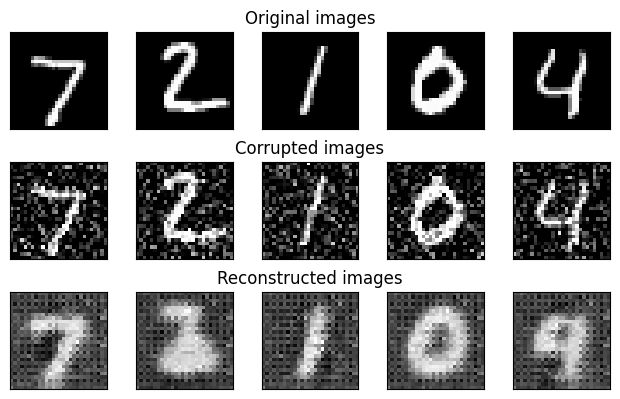

EPOCH 2/30
	 partial train loss (single batch): 0.067037
	 partial train loss (single batch): 0.066929
	 partial train loss (single batch): 0.067239
	 partial train loss (single batch): 0.067093
	 partial train loss (single batch): 0.066320
	 partial train loss (single batch): 0.066468
	 partial train loss (single batch): 0.066632
	 partial train loss (single batch): 0.066324
	 partial train loss (single batch): 0.066267
	 partial train loss (single batch): 0.066137
	 partial train loss (single batch): 0.065679
	 partial train loss (single batch): 0.066576
	 partial train loss (single batch): 0.067315
	 partial train loss (single batch): 0.066118
	 partial train loss (single batch): 0.065255
	 partial train loss (single batch): 0.066738
	 partial train loss (single batch): 0.066179
	 partial train loss (single batch): 0.066476
	 partial train loss (single batch): 0.065244
	 partial train loss (single batch): 0.066243
	 partial train loss (single batch): 0.065110
	 partial train loss (s

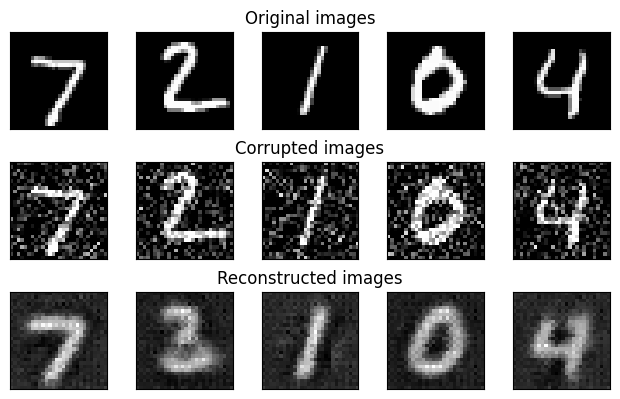

EPOCH 3/30
	 partial train loss (single batch): 0.058466
	 partial train loss (single batch): 0.058540
	 partial train loss (single batch): 0.058916
	 partial train loss (single batch): 0.058285
	 partial train loss (single batch): 0.057898
	 partial train loss (single batch): 0.058382
	 partial train loss (single batch): 0.058146
	 partial train loss (single batch): 0.057697
	 partial train loss (single batch): 0.058408
	 partial train loss (single batch): 0.058045
	 partial train loss (single batch): 0.057603
	 partial train loss (single batch): 0.058600
	 partial train loss (single batch): 0.059309
	 partial train loss (single batch): 0.057573
	 partial train loss (single batch): 0.057489
	 partial train loss (single batch): 0.058288
	 partial train loss (single batch): 0.059207
	 partial train loss (single batch): 0.058939
	 partial train loss (single batch): 0.057056
	 partial train loss (single batch): 0.058336
	 partial train loss (single batch): 0.057537
	 partial train loss (s

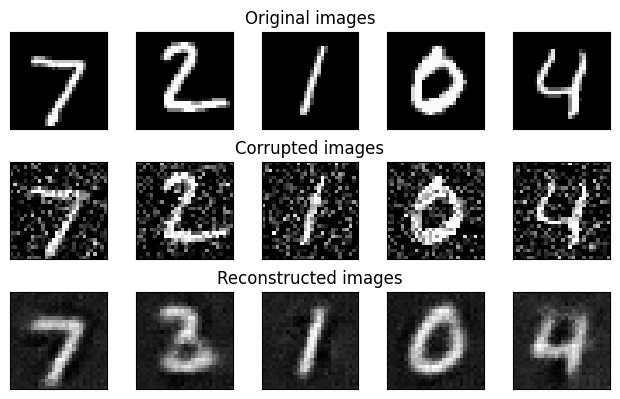

EPOCH 4/30
	 partial train loss (single batch): 0.054116
	 partial train loss (single batch): 0.055218
	 partial train loss (single batch): 0.054415
	 partial train loss (single batch): 0.054287
	 partial train loss (single batch): 0.054059
	 partial train loss (single batch): 0.054485
	 partial train loss (single batch): 0.054216
	 partial train loss (single batch): 0.054119
	 partial train loss (single batch): 0.054866
	 partial train loss (single batch): 0.054435
	 partial train loss (single batch): 0.054187
	 partial train loss (single batch): 0.055119
	 partial train loss (single batch): 0.055280
	 partial train loss (single batch): 0.054358
	 partial train loss (single batch): 0.053484
	 partial train loss (single batch): 0.054713
	 partial train loss (single batch): 0.055290
	 partial train loss (single batch): 0.055532
	 partial train loss (single batch): 0.053902
	 partial train loss (single batch): 0.054842
	 partial train loss (single batch): 0.053737
	 partial train loss (s

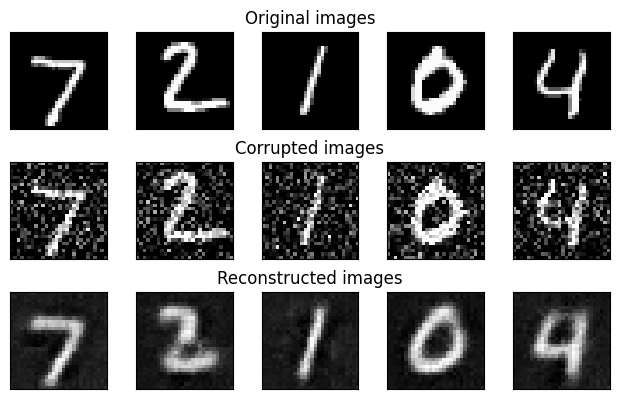

EPOCH 5/30
	 partial train loss (single batch): 0.052661
	 partial train loss (single batch): 0.053675
	 partial train loss (single batch): 0.052637
	 partial train loss (single batch): 0.052757
	 partial train loss (single batch): 0.052709
	 partial train loss (single batch): 0.052926
	 partial train loss (single batch): 0.052569
	 partial train loss (single batch): 0.052910
	 partial train loss (single batch): 0.053635
	 partial train loss (single batch): 0.053296
	 partial train loss (single batch): 0.052563
	 partial train loss (single batch): 0.053697
	 partial train loss (single batch): 0.054063
	 partial train loss (single batch): 0.053082
	 partial train loss (single batch): 0.052266
	 partial train loss (single batch): 0.053334
	 partial train loss (single batch): 0.053999
	 partial train loss (single batch): 0.054074
	 partial train loss (single batch): 0.052333
	 partial train loss (single batch): 0.053474
	 partial train loss (single batch): 0.052682
	 partial train loss (s

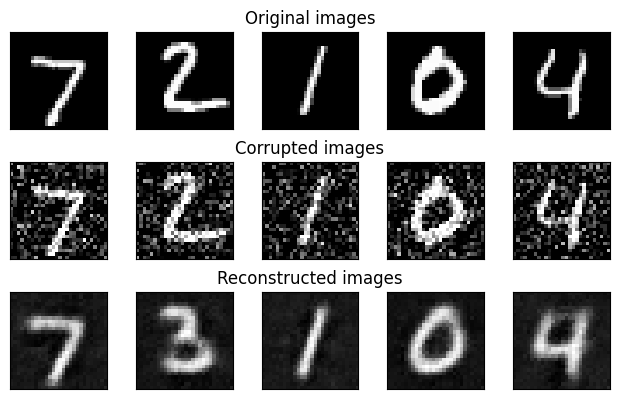

EPOCH 6/30
	 partial train loss (single batch): 0.052184
	 partial train loss (single batch): 0.052925
	 partial train loss (single batch): 0.052003
	 partial train loss (single batch): 0.052018
	 partial train loss (single batch): 0.051847
	 partial train loss (single batch): 0.052276
	 partial train loss (single batch): 0.052142
	 partial train loss (single batch): 0.052342
	 partial train loss (single batch): 0.052840
	 partial train loss (single batch): 0.052196
	 partial train loss (single batch): 0.051762
	 partial train loss (single batch): 0.052817
	 partial train loss (single batch): 0.053567
	 partial train loss (single batch): 0.052472
	 partial train loss (single batch): 0.051564
	 partial train loss (single batch): 0.052446
	 partial train loss (single batch): 0.053020
	 partial train loss (single batch): 0.053159
	 partial train loss (single batch): 0.051490
	 partial train loss (single batch): 0.052373
	 partial train loss (single batch): 0.052133
	 partial train loss (s

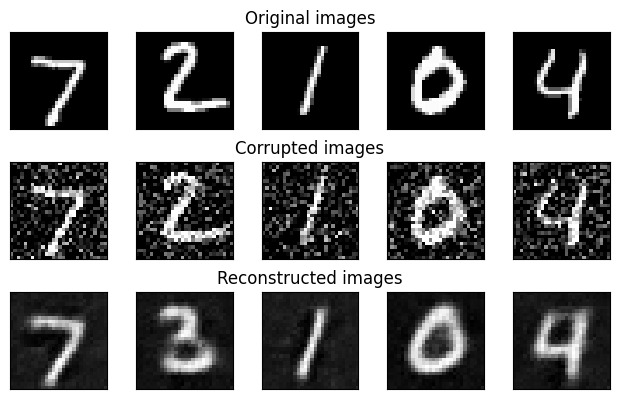

EPOCH 7/30
	 partial train loss (single batch): 0.051702
	 partial train loss (single batch): 0.052554
	 partial train loss (single batch): 0.051771
	 partial train loss (single batch): 0.052158
	 partial train loss (single batch): 0.051069
	 partial train loss (single batch): 0.052024
	 partial train loss (single batch): 0.051502
	 partial train loss (single batch): 0.051759
	 partial train loss (single batch): 0.052624
	 partial train loss (single batch): 0.051997
	 partial train loss (single batch): 0.051381
	 partial train loss (single batch): 0.052460
	 partial train loss (single batch): 0.052766
	 partial train loss (single batch): 0.052232
	 partial train loss (single batch): 0.051111
	 partial train loss (single batch): 0.052132
	 partial train loss (single batch): 0.052583
	 partial train loss (single batch): 0.052869
	 partial train loss (single batch): 0.051175
	 partial train loss (single batch): 0.051913
	 partial train loss (single batch): 0.051335
	 partial train loss (s

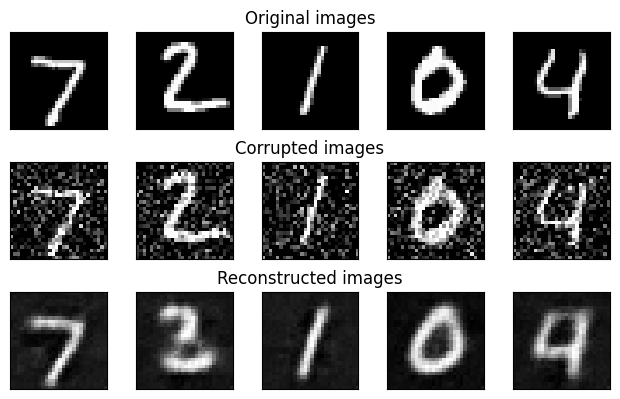

EPOCH 8/30
	 partial train loss (single batch): 0.051378
	 partial train loss (single batch): 0.052575
	 partial train loss (single batch): 0.051729
	 partial train loss (single batch): 0.051251
	 partial train loss (single batch): 0.051156
	 partial train loss (single batch): 0.051511
	 partial train loss (single batch): 0.051031
	 partial train loss (single batch): 0.051414
	 partial train loss (single batch): 0.052101
	 partial train loss (single batch): 0.051634
	 partial train loss (single batch): 0.050676
	 partial train loss (single batch): 0.051782
	 partial train loss (single batch): 0.052467
	 partial train loss (single batch): 0.051583
	 partial train loss (single batch): 0.050828
	 partial train loss (single batch): 0.051606
	 partial train loss (single batch): 0.052625
	 partial train loss (single batch): 0.052846
	 partial train loss (single batch): 0.050554
	 partial train loss (single batch): 0.051743
	 partial train loss (single batch): 0.051018
	 partial train loss (s

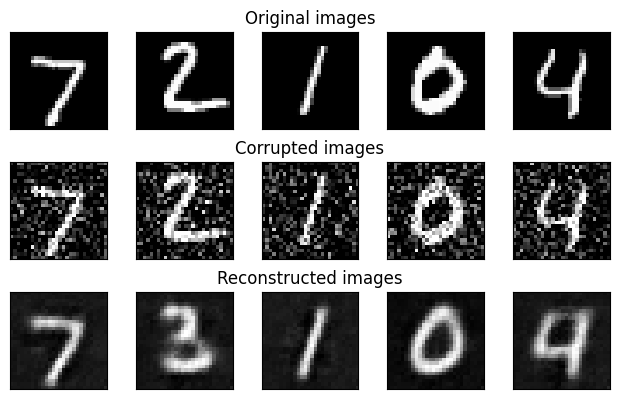

EPOCH 9/30
	 partial train loss (single batch): 0.051071
	 partial train loss (single batch): 0.052245
	 partial train loss (single batch): 0.051255
	 partial train loss (single batch): 0.051133
	 partial train loss (single batch): 0.050503
	 partial train loss (single batch): 0.051096
	 partial train loss (single batch): 0.051281
	 partial train loss (single batch): 0.051171
	 partial train loss (single batch): 0.051787
	 partial train loss (single batch): 0.051247
	 partial train loss (single batch): 0.050823
	 partial train loss (single batch): 0.051954
	 partial train loss (single batch): 0.052433
	 partial train loss (single batch): 0.051334
	 partial train loss (single batch): 0.050633
	 partial train loss (single batch): 0.051368
	 partial train loss (single batch): 0.052347
	 partial train loss (single batch): 0.052481
	 partial train loss (single batch): 0.050461
	 partial train loss (single batch): 0.051322
	 partial train loss (single batch): 0.051160
	 partial train loss (s

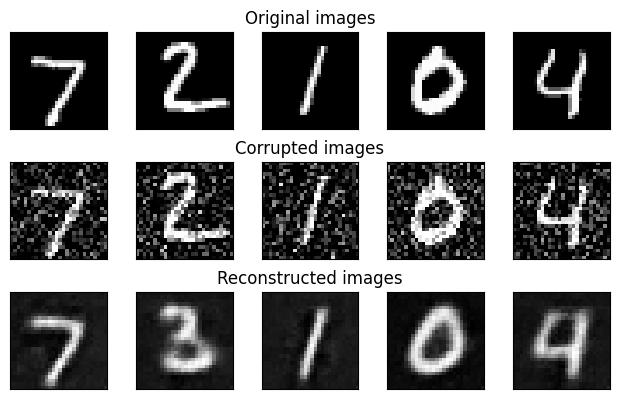

EPOCH 10/30
	 partial train loss (single batch): 0.050886
	 partial train loss (single batch): 0.051939
	 partial train loss (single batch): 0.051256
	 partial train loss (single batch): 0.051064
	 partial train loss (single batch): 0.050874
	 partial train loss (single batch): 0.050735
	 partial train loss (single batch): 0.050621
	 partial train loss (single batch): 0.051182
	 partial train loss (single batch): 0.051870
	 partial train loss (single batch): 0.051273
	 partial train loss (single batch): 0.050798
	 partial train loss (single batch): 0.051496
	 partial train loss (single batch): 0.052230
	 partial train loss (single batch): 0.051276
	 partial train loss (single batch): 0.050496
	 partial train loss (single batch): 0.051321
	 partial train loss (single batch): 0.051704
	 partial train loss (single batch): 0.052216
	 partial train loss (single batch): 0.050371
	 partial train loss (single batch): 0.050927
	 partial train loss (single batch): 0.050934
	 partial train loss (

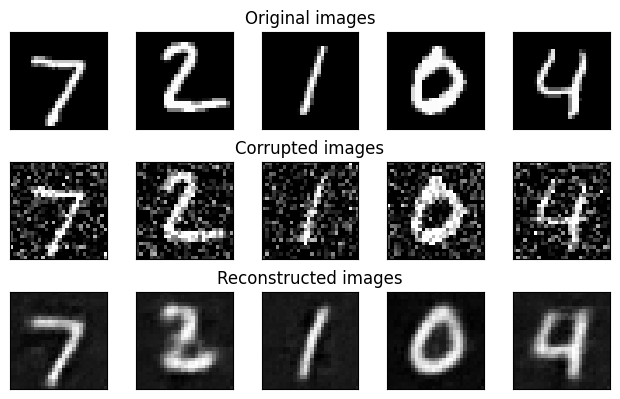

EPOCH 11/30
	 partial train loss (single batch): 0.050825
	 partial train loss (single batch): 0.051752
	 partial train loss (single batch): 0.050787
	 partial train loss (single batch): 0.050434
	 partial train loss (single batch): 0.050340
	 partial train loss (single batch): 0.050828
	 partial train loss (single batch): 0.050472
	 partial train loss (single batch): 0.051071
	 partial train loss (single batch): 0.051308
	 partial train loss (single batch): 0.050959
	 partial train loss (single batch): 0.050697
	 partial train loss (single batch): 0.051500
	 partial train loss (single batch): 0.052082
	 partial train loss (single batch): 0.050913
	 partial train loss (single batch): 0.050278
	 partial train loss (single batch): 0.051315
	 partial train loss (single batch): 0.051613
	 partial train loss (single batch): 0.051974
	 partial train loss (single batch): 0.050261
	 partial train loss (single batch): 0.050708
	 partial train loss (single batch): 0.050748
	 partial train loss (

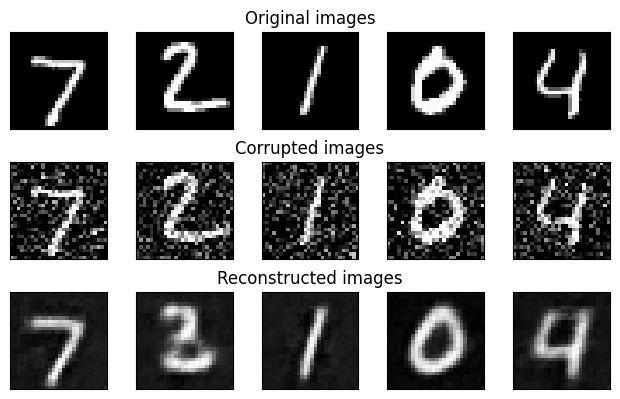

EPOCH 12/30
	 partial train loss (single batch): 0.050488
	 partial train loss (single batch): 0.051591
	 partial train loss (single batch): 0.050755
	 partial train loss (single batch): 0.050635
	 partial train loss (single batch): 0.050304
	 partial train loss (single batch): 0.050613
	 partial train loss (single batch): 0.050271
	 partial train loss (single batch): 0.050462
	 partial train loss (single batch): 0.051574
	 partial train loss (single batch): 0.050801
	 partial train loss (single batch): 0.050293
	 partial train loss (single batch): 0.051423
	 partial train loss (single batch): 0.051876
	 partial train loss (single batch): 0.051113
	 partial train loss (single batch): 0.050076
	 partial train loss (single batch): 0.050917
	 partial train loss (single batch): 0.051886
	 partial train loss (single batch): 0.052248
	 partial train loss (single batch): 0.049716
	 partial train loss (single batch): 0.050814
	 partial train loss (single batch): 0.050355
	 partial train loss (

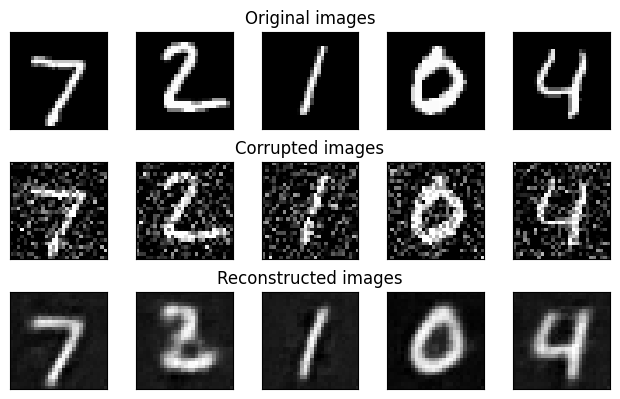

EPOCH 13/30
	 partial train loss (single batch): 0.050170
	 partial train loss (single batch): 0.051326
	 partial train loss (single batch): 0.050524
	 partial train loss (single batch): 0.050314
	 partial train loss (single batch): 0.050069
	 partial train loss (single batch): 0.050392
	 partial train loss (single batch): 0.049934
	 partial train loss (single batch): 0.050470
	 partial train loss (single batch): 0.051220
	 partial train loss (single batch): 0.050621
	 partial train loss (single batch): 0.050239
	 partial train loss (single batch): 0.051336
	 partial train loss (single batch): 0.052228
	 partial train loss (single batch): 0.050646
	 partial train loss (single batch): 0.050139
	 partial train loss (single batch): 0.050387
	 partial train loss (single batch): 0.051328
	 partial train loss (single batch): 0.051768
	 partial train loss (single batch): 0.049775
	 partial train loss (single batch): 0.050456
	 partial train loss (single batch): 0.050321
	 partial train loss (

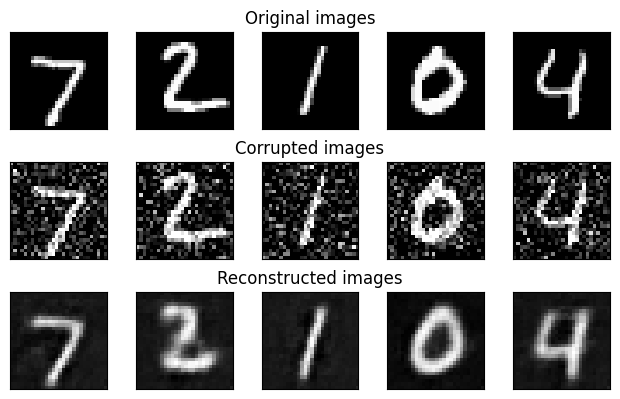

EPOCH 14/30
	 partial train loss (single batch): 0.049748
	 partial train loss (single batch): 0.051456
	 partial train loss (single batch): 0.050492
	 partial train loss (single batch): 0.050569
	 partial train loss (single batch): 0.049791
	 partial train loss (single batch): 0.050115
	 partial train loss (single batch): 0.050054
	 partial train loss (single batch): 0.050543
	 partial train loss (single batch): 0.051345
	 partial train loss (single batch): 0.050458
	 partial train loss (single batch): 0.050256
	 partial train loss (single batch): 0.050892
	 partial train loss (single batch): 0.051473
	 partial train loss (single batch): 0.050427
	 partial train loss (single batch): 0.049762
	 partial train loss (single batch): 0.050696
	 partial train loss (single batch): 0.051221
	 partial train loss (single batch): 0.051732
	 partial train loss (single batch): 0.049749
	 partial train loss (single batch): 0.050564
	 partial train loss (single batch): 0.050209
	 partial train loss (

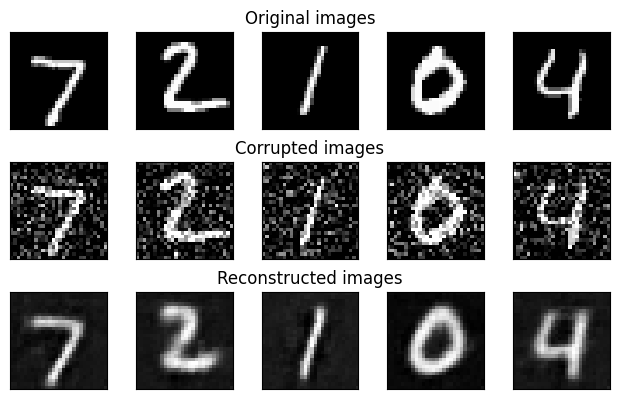

EPOCH 15/30
	 partial train loss (single batch): 0.050273
	 partial train loss (single batch): 0.051482
	 partial train loss (single batch): 0.050443
	 partial train loss (single batch): 0.049924
	 partial train loss (single batch): 0.049673
	 partial train loss (single batch): 0.050137
	 partial train loss (single batch): 0.050034
	 partial train loss (single batch): 0.050260
	 partial train loss (single batch): 0.050949
	 partial train loss (single batch): 0.050389
	 partial train loss (single batch): 0.050200
	 partial train loss (single batch): 0.050959
	 partial train loss (single batch): 0.051585
	 partial train loss (single batch): 0.050465
	 partial train loss (single batch): 0.049584
	 partial train loss (single batch): 0.050911
	 partial train loss (single batch): 0.051022
	 partial train loss (single batch): 0.052007
	 partial train loss (single batch): 0.049678
	 partial train loss (single batch): 0.050161
	 partial train loss (single batch): 0.049834
	 partial train loss (

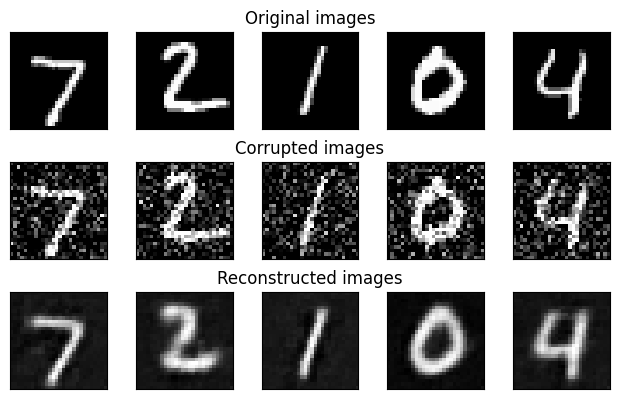

EPOCH 16/30
	 partial train loss (single batch): 0.050168
	 partial train loss (single batch): 0.051415
	 partial train loss (single batch): 0.050195
	 partial train loss (single batch): 0.050047
	 partial train loss (single batch): 0.049664
	 partial train loss (single batch): 0.049940
	 partial train loss (single batch): 0.049860
	 partial train loss (single batch): 0.050370
	 partial train loss (single batch): 0.051240
	 partial train loss (single batch): 0.050463
	 partial train loss (single batch): 0.049677
	 partial train loss (single batch): 0.050729
	 partial train loss (single batch): 0.051292
	 partial train loss (single batch): 0.050316
	 partial train loss (single batch): 0.049686
	 partial train loss (single batch): 0.050621
	 partial train loss (single batch): 0.051048
	 partial train loss (single batch): 0.051568
	 partial train loss (single batch): 0.049354
	 partial train loss (single batch): 0.050159
	 partial train loss (single batch): 0.049648
	 partial train loss (

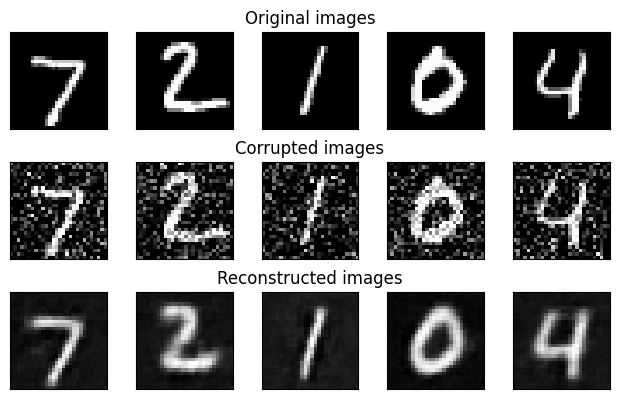

EPOCH 17/30
	 partial train loss (single batch): 0.049658
	 partial train loss (single batch): 0.051346
	 partial train loss (single batch): 0.050073
	 partial train loss (single batch): 0.050134
	 partial train loss (single batch): 0.049853
	 partial train loss (single batch): 0.050326
	 partial train loss (single batch): 0.049741
	 partial train loss (single batch): 0.049900
	 partial train loss (single batch): 0.051294
	 partial train loss (single batch): 0.050359
	 partial train loss (single batch): 0.049580
	 partial train loss (single batch): 0.050540
	 partial train loss (single batch): 0.051396
	 partial train loss (single batch): 0.050372
	 partial train loss (single batch): 0.049568
	 partial train loss (single batch): 0.050288
	 partial train loss (single batch): 0.051136
	 partial train loss (single batch): 0.051280
	 partial train loss (single batch): 0.049588
	 partial train loss (single batch): 0.050139
	 partial train loss (single batch): 0.049816
	 partial train loss (

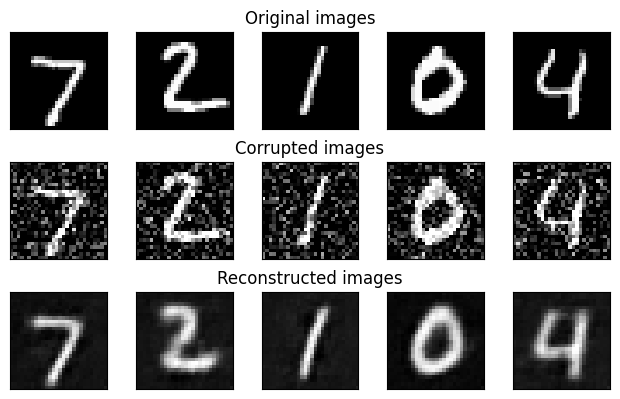

EPOCH 18/30
	 partial train loss (single batch): 0.049799
	 partial train loss (single batch): 0.051078
	 partial train loss (single batch): 0.049951
	 partial train loss (single batch): 0.050257
	 partial train loss (single batch): 0.049368
	 partial train loss (single batch): 0.050208
	 partial train loss (single batch): 0.049559
	 partial train loss (single batch): 0.050241
	 partial train loss (single batch): 0.050579
	 partial train loss (single batch): 0.050124
	 partial train loss (single batch): 0.049512
	 partial train loss (single batch): 0.050805
	 partial train loss (single batch): 0.051082
	 partial train loss (single batch): 0.050107
	 partial train loss (single batch): 0.049217
	 partial train loss (single batch): 0.050340
	 partial train loss (single batch): 0.050880
	 partial train loss (single batch): 0.051056
	 partial train loss (single batch): 0.049314
	 partial train loss (single batch): 0.049933
	 partial train loss (single batch): 0.049737
	 partial train loss (

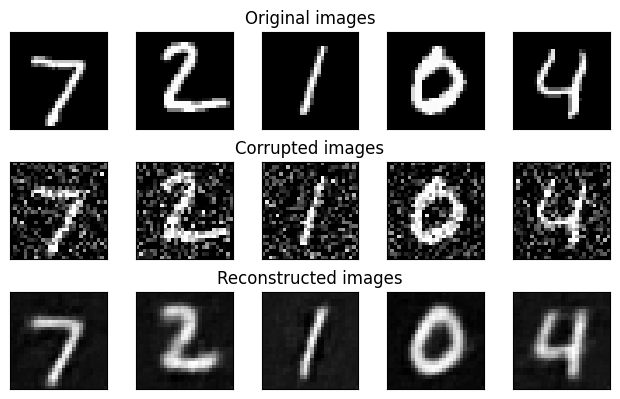

EPOCH 19/30
	 partial train loss (single batch): 0.049610
	 partial train loss (single batch): 0.050999
	 partial train loss (single batch): 0.049910
	 partial train loss (single batch): 0.049997
	 partial train loss (single batch): 0.049319
	 partial train loss (single batch): 0.049592
	 partial train loss (single batch): 0.049600
	 partial train loss (single batch): 0.049490
	 partial train loss (single batch): 0.050753
	 partial train loss (single batch): 0.050085
	 partial train loss (single batch): 0.049361
	 partial train loss (single batch): 0.050283
	 partial train loss (single batch): 0.051155
	 partial train loss (single batch): 0.049950
	 partial train loss (single batch): 0.049526
	 partial train loss (single batch): 0.050191
	 partial train loss (single batch): 0.050503
	 partial train loss (single batch): 0.051042
	 partial train loss (single batch): 0.049370
	 partial train loss (single batch): 0.049990
	 partial train loss (single batch): 0.049669
	 partial train loss (

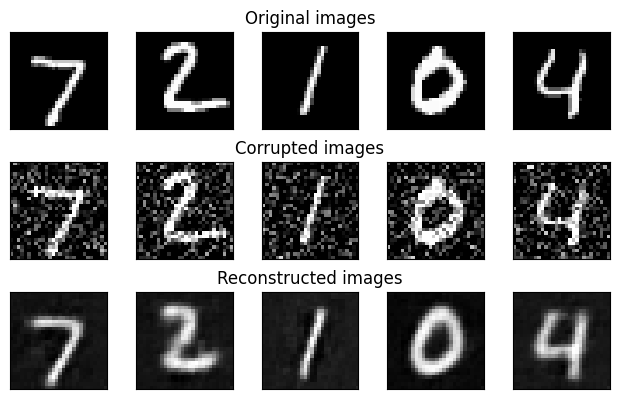

EPOCH 20/30
	 partial train loss (single batch): 0.049124
	 partial train loss (single batch): 0.050767
	 partial train loss (single batch): 0.050099
	 partial train loss (single batch): 0.049635
	 partial train loss (single batch): 0.049477
	 partial train loss (single batch): 0.049530
	 partial train loss (single batch): 0.049824
	 partial train loss (single batch): 0.049880
	 partial train loss (single batch): 0.050786
	 partial train loss (single batch): 0.049958
	 partial train loss (single batch): 0.049368
	 partial train loss (single batch): 0.050240
	 partial train loss (single batch): 0.051037
	 partial train loss (single batch): 0.049804
	 partial train loss (single batch): 0.049204
	 partial train loss (single batch): 0.050297
	 partial train loss (single batch): 0.050626
	 partial train loss (single batch): 0.051204
	 partial train loss (single batch): 0.049760
	 partial train loss (single batch): 0.049994
	 partial train loss (single batch): 0.049528
	 partial train loss (

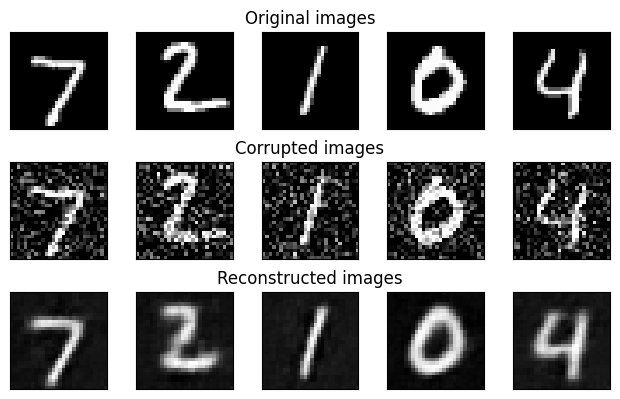

EPOCH 21/30
	 partial train loss (single batch): 0.049541
	 partial train loss (single batch): 0.051053
	 partial train loss (single batch): 0.049927
	 partial train loss (single batch): 0.049759
	 partial train loss (single batch): 0.049498
	 partial train loss (single batch): 0.049674
	 partial train loss (single batch): 0.049492
	 partial train loss (single batch): 0.049663
	 partial train loss (single batch): 0.050700
	 partial train loss (single batch): 0.049847
	 partial train loss (single batch): 0.049506
	 partial train loss (single batch): 0.050726
	 partial train loss (single batch): 0.051111
	 partial train loss (single batch): 0.049792
	 partial train loss (single batch): 0.049317
	 partial train loss (single batch): 0.049924
	 partial train loss (single batch): 0.050204
	 partial train loss (single batch): 0.051327
	 partial train loss (single batch): 0.049702
	 partial train loss (single batch): 0.049705
	 partial train loss (single batch): 0.049646
	 partial train loss (

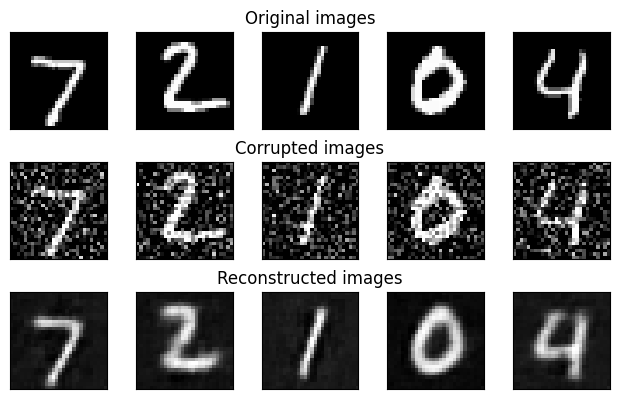

EPOCH 22/30
	 partial train loss (single batch): 0.049288
	 partial train loss (single batch): 0.050738
	 partial train loss (single batch): 0.049613
	 partial train loss (single batch): 0.049459
	 partial train loss (single batch): 0.049180
	 partial train loss (single batch): 0.049923
	 partial train loss (single batch): 0.049544
	 partial train loss (single batch): 0.049609
	 partial train loss (single batch): 0.050807
	 partial train loss (single batch): 0.050047
	 partial train loss (single batch): 0.049243
	 partial train loss (single batch): 0.050726
	 partial train loss (single batch): 0.051055
	 partial train loss (single batch): 0.049875
	 partial train loss (single batch): 0.049165
	 partial train loss (single batch): 0.049853
	 partial train loss (single batch): 0.050430
	 partial train loss (single batch): 0.051020
	 partial train loss (single batch): 0.049424
	 partial train loss (single batch): 0.049785
	 partial train loss (single batch): 0.049629
	 partial train loss (

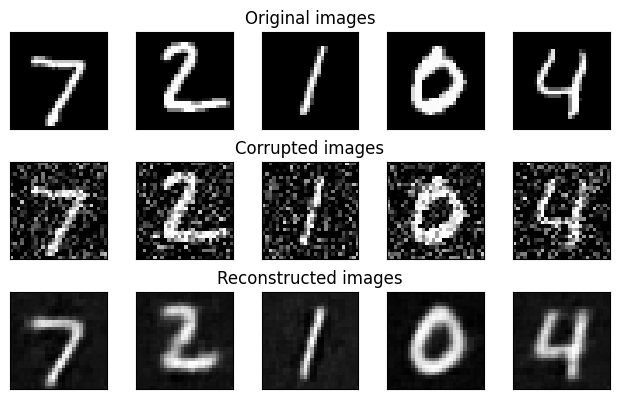

EPOCH 23/30
	 partial train loss (single batch): 0.049104
	 partial train loss (single batch): 0.050562
	 partial train loss (single batch): 0.049865
	 partial train loss (single batch): 0.049371
	 partial train loss (single batch): 0.049025
	 partial train loss (single batch): 0.049678
	 partial train loss (single batch): 0.049109
	 partial train loss (single batch): 0.049652
	 partial train loss (single batch): 0.050541
	 partial train loss (single batch): 0.049772
	 partial train loss (single batch): 0.049176
	 partial train loss (single batch): 0.050004
	 partial train loss (single batch): 0.050722
	 partial train loss (single batch): 0.049863
	 partial train loss (single batch): 0.049059
	 partial train loss (single batch): 0.049942
	 partial train loss (single batch): 0.050640
	 partial train loss (single batch): 0.050860
	 partial train loss (single batch): 0.049124
	 partial train loss (single batch): 0.049669
	 partial train loss (single batch): 0.049342
	 partial train loss (

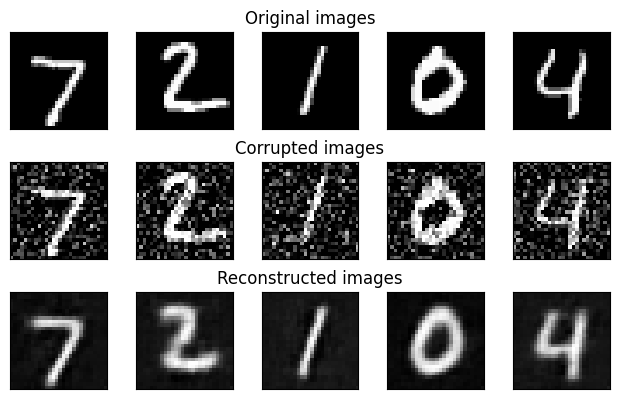

EPOCH 24/30
	 partial train loss (single batch): 0.048920
	 partial train loss (single batch): 0.050541
	 partial train loss (single batch): 0.049702
	 partial train loss (single batch): 0.049328
	 partial train loss (single batch): 0.049405
	 partial train loss (single batch): 0.049507
	 partial train loss (single batch): 0.049114
	 partial train loss (single batch): 0.049737
	 partial train loss (single batch): 0.050548
	 partial train loss (single batch): 0.049819
	 partial train loss (single batch): 0.048875
	 partial train loss (single batch): 0.050366
	 partial train loss (single batch): 0.050574
	 partial train loss (single batch): 0.049562
	 partial train loss (single batch): 0.048971
	 partial train loss (single batch): 0.049870
	 partial train loss (single batch): 0.050380
	 partial train loss (single batch): 0.050692
	 partial train loss (single batch): 0.049313
	 partial train loss (single batch): 0.049758
	 partial train loss (single batch): 0.049204
	 partial train loss (

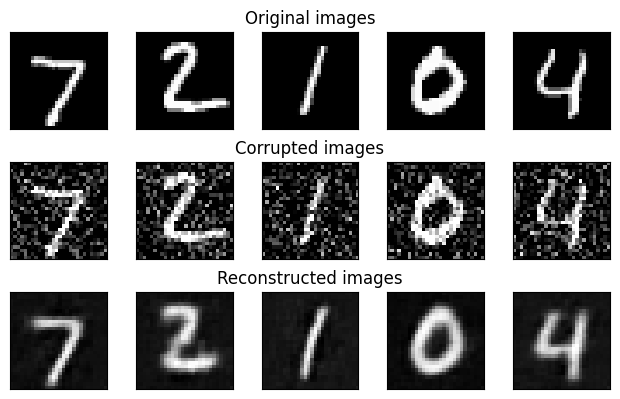

EPOCH 25/30
	 partial train loss (single batch): 0.049129
	 partial train loss (single batch): 0.050692
	 partial train loss (single batch): 0.049853
	 partial train loss (single batch): 0.049258
	 partial train loss (single batch): 0.049231
	 partial train loss (single batch): 0.049355
	 partial train loss (single batch): 0.049265
	 partial train loss (single batch): 0.049464
	 partial train loss (single batch): 0.050321
	 partial train loss (single batch): 0.050167
	 partial train loss (single batch): 0.048866
	 partial train loss (single batch): 0.050243
	 partial train loss (single batch): 0.050678
	 partial train loss (single batch): 0.049480
	 partial train loss (single batch): 0.049006
	 partial train loss (single batch): 0.049804
	 partial train loss (single batch): 0.050330
	 partial train loss (single batch): 0.050806
	 partial train loss (single batch): 0.048960
	 partial train loss (single batch): 0.049560
	 partial train loss (single batch): 0.049467
	 partial train loss (

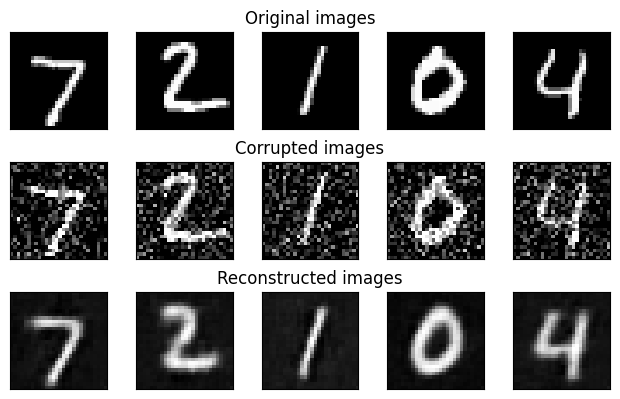

EPOCH 26/30
	 partial train loss (single batch): 0.049332
	 partial train loss (single batch): 0.050624
	 partial train loss (single batch): 0.049522
	 partial train loss (single batch): 0.049165
	 partial train loss (single batch): 0.049234
	 partial train loss (single batch): 0.049476
	 partial train loss (single batch): 0.049107
	 partial train loss (single batch): 0.049510
	 partial train loss (single batch): 0.050663
	 partial train loss (single batch): 0.049703
	 partial train loss (single batch): 0.048865
	 partial train loss (single batch): 0.050077
	 partial train loss (single batch): 0.050559
	 partial train loss (single batch): 0.049454
	 partial train loss (single batch): 0.048809
	 partial train loss (single batch): 0.049438
	 partial train loss (single batch): 0.050172
	 partial train loss (single batch): 0.050771
	 partial train loss (single batch): 0.049322
	 partial train loss (single batch): 0.049761
	 partial train loss (single batch): 0.049430
	 partial train loss (

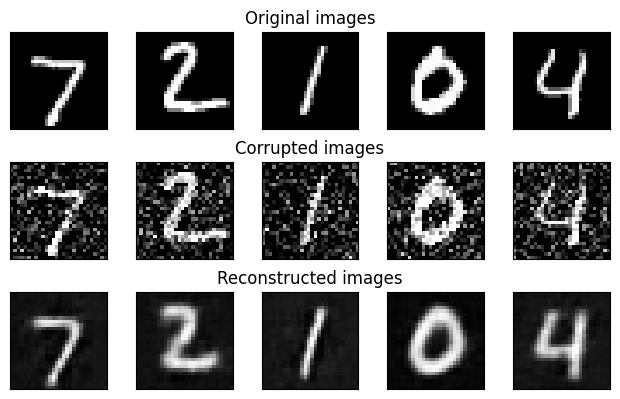

EPOCH 27/30
	 partial train loss (single batch): 0.048800
	 partial train loss (single batch): 0.050570
	 partial train loss (single batch): 0.049364
	 partial train loss (single batch): 0.049464
	 partial train loss (single batch): 0.049017
	 partial train loss (single batch): 0.049447
	 partial train loss (single batch): 0.049027
	 partial train loss (single batch): 0.049615
	 partial train loss (single batch): 0.050492
	 partial train loss (single batch): 0.049731
	 partial train loss (single batch): 0.048764
	 partial train loss (single batch): 0.050254
	 partial train loss (single batch): 0.050552
	 partial train loss (single batch): 0.049455
	 partial train loss (single batch): 0.048810
	 partial train loss (single batch): 0.049618
	 partial train loss (single batch): 0.050539
	 partial train loss (single batch): 0.050597
	 partial train loss (single batch): 0.048847
	 partial train loss (single batch): 0.049637
	 partial train loss (single batch): 0.049035
	 partial train loss (

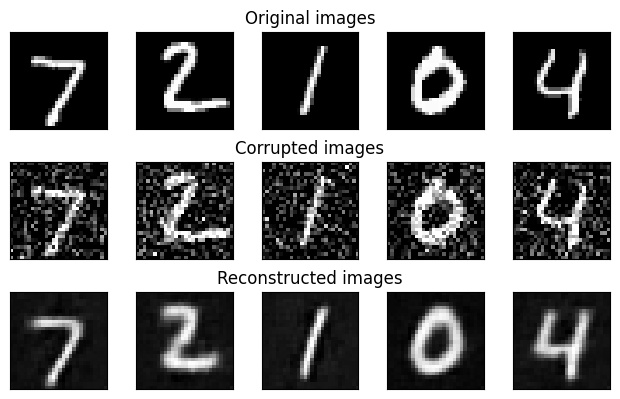

EPOCH 28/30
	 partial train loss (single batch): 0.048995
	 partial train loss (single batch): 0.050097
	 partial train loss (single batch): 0.049498
	 partial train loss (single batch): 0.049448
	 partial train loss (single batch): 0.049198
	 partial train loss (single batch): 0.049614
	 partial train loss (single batch): 0.048952
	 partial train loss (single batch): 0.049485
	 partial train loss (single batch): 0.050635
	 partial train loss (single batch): 0.050075
	 partial train loss (single batch): 0.048837
	 partial train loss (single batch): 0.050288
	 partial train loss (single batch): 0.050622
	 partial train loss (single batch): 0.049483
	 partial train loss (single batch): 0.048766
	 partial train loss (single batch): 0.049519
	 partial train loss (single batch): 0.050351
	 partial train loss (single batch): 0.050748
	 partial train loss (single batch): 0.048916
	 partial train loss (single batch): 0.049445
	 partial train loss (single batch): 0.049291
	 partial train loss (

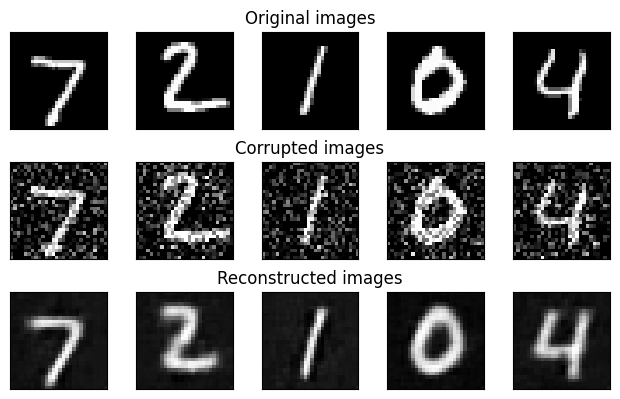

EPOCH 29/30
	 partial train loss (single batch): 0.048734
	 partial train loss (single batch): 0.050196
	 partial train loss (single batch): 0.049839
	 partial train loss (single batch): 0.049415
	 partial train loss (single batch): 0.048926
	 partial train loss (single batch): 0.049522
	 partial train loss (single batch): 0.048571
	 partial train loss (single batch): 0.049407
	 partial train loss (single batch): 0.050345
	 partial train loss (single batch): 0.049643
	 partial train loss (single batch): 0.048673
	 partial train loss (single batch): 0.050045
	 partial train loss (single batch): 0.050613
	 partial train loss (single batch): 0.049509
	 partial train loss (single batch): 0.048506
	 partial train loss (single batch): 0.049579
	 partial train loss (single batch): 0.049926
	 partial train loss (single batch): 0.050747
	 partial train loss (single batch): 0.048979
	 partial train loss (single batch): 0.049506
	 partial train loss (single batch): 0.049299
	 partial train loss (

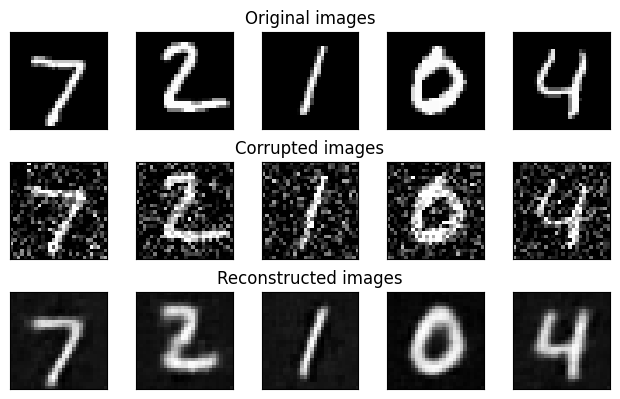

EPOCH 30/30
	 partial train loss (single batch): 0.048910
	 partial train loss (single batch): 0.050531
	 partial train loss (single batch): 0.049610
	 partial train loss (single batch): 0.049200
	 partial train loss (single batch): 0.048978
	 partial train loss (single batch): 0.049032
	 partial train loss (single batch): 0.048996
	 partial train loss (single batch): 0.049305
	 partial train loss (single batch): 0.050364
	 partial train loss (single batch): 0.049588
	 partial train loss (single batch): 0.049028
	 partial train loss (single batch): 0.049868
	 partial train loss (single batch): 0.050895
	 partial train loss (single batch): 0.049661
	 partial train loss (single batch): 0.048928
	 partial train loss (single batch): 0.049580
	 partial train loss (single batch): 0.049915
	 partial train loss (single batch): 0.050661
	 partial train loss (single batch): 0.048939
	 partial train loss (single batch): 0.049414
	 partial train loss (single batch): 0.049537
	 partial train loss (

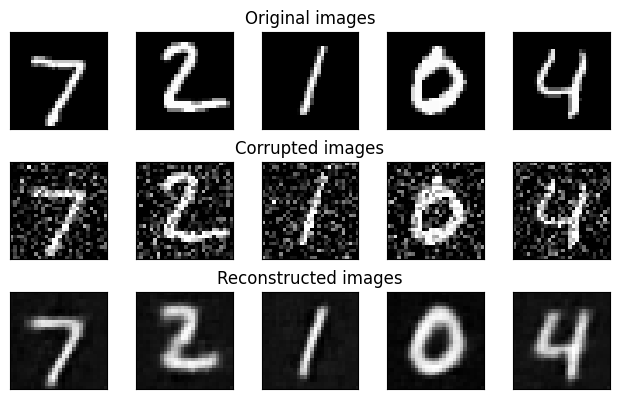

In [17]:
### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)


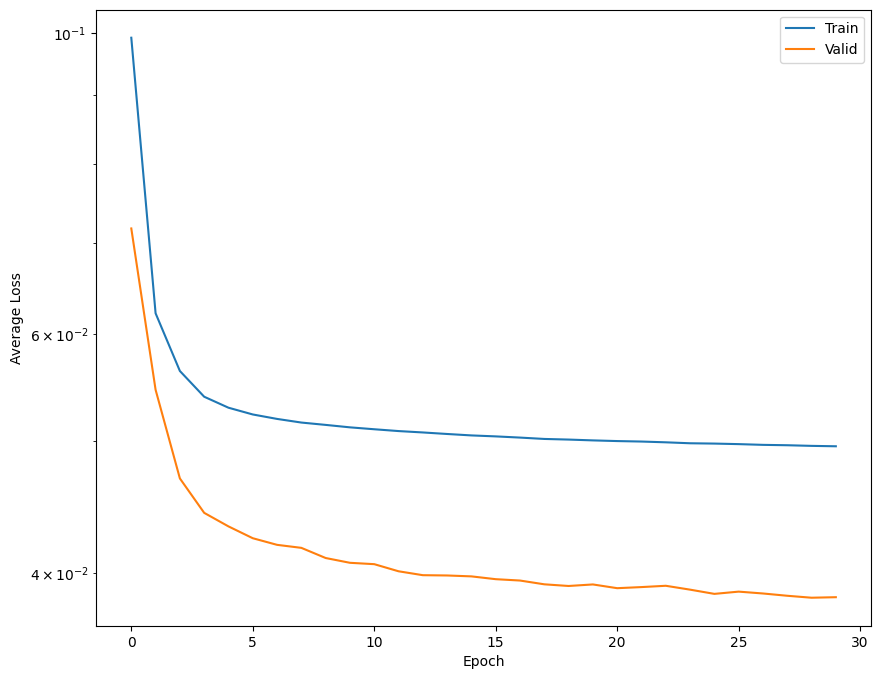

In [18]:
# Plot training performance
test_epoch_den(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history_da['train_loss'], label='Train')
plt.semilogy(history_da['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## 4 Visualize latent space

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1907.66it/s]


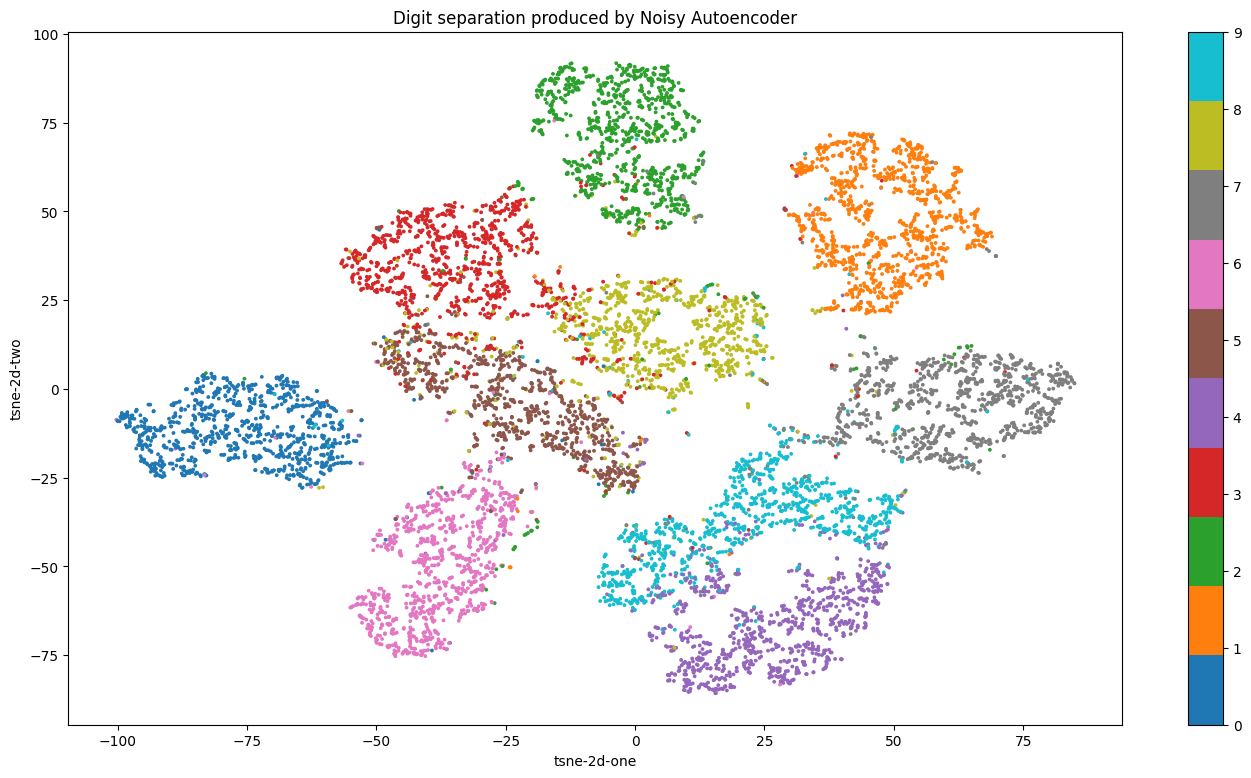

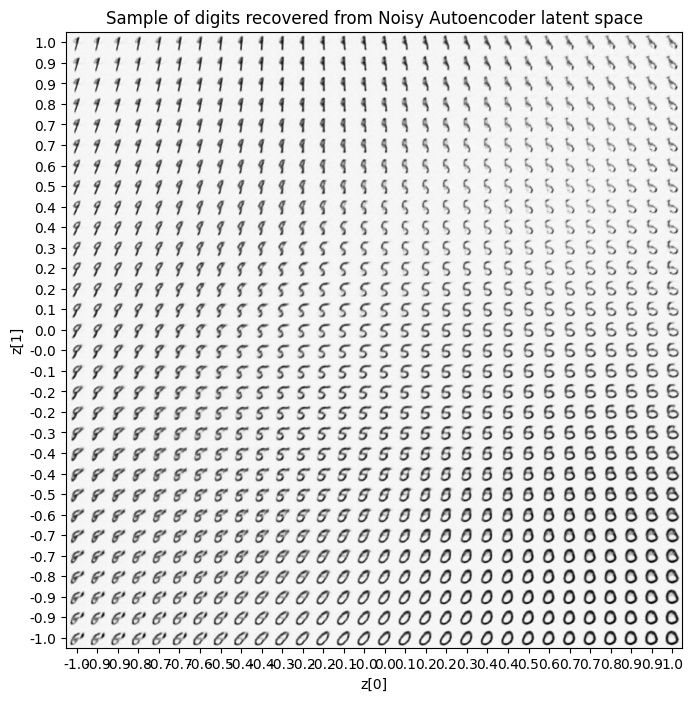

In [19]:
def plot_results(encoder, decoder, data, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    # Encode all data samples
    encoded_samples = []
    for sample in tqdm(data):
        
        # Separate image data from its label 
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
        
        # Find latend dimension from decoded image
        latent_dim = len(encoded_img)
        
    encoded_samples = pd.DataFrame(encoded_samples)

    # Create a TSNE model and plot it
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
    
    plt.figure(figsize=(17, 9))
    plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10', s=3)
    plt.xlabel('tsne-2d-one')
    plt.ylabel('tsne-2d-two')
    plt.title(f'Digit separation produced by {model_name}')
    plt.colorbar()
    plt.show()
    
    # Prepare a n x n 2D matrix of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # Create a linearly spaced coordinates of 2D digit classes in latent space
    grid_x = np.linspace(*rx, n)
    grid_y = np.linspace(*ry, n)[::-1]

    # Populate the matrix with images decoded from latent space
    for i, yi in enumerate(grid_y):
        for j, xj in enumerate(grid_x):
            # coords = [xj, yi, 0, 0] # Use latent_dim
            coords = list(np.zeros(latent_dim))
            coords[0] = xj
            coords[1] = yi
            z = torch.Tensor([coords]).to(device)
            x_hat = decoder(z)
            digit = x_hat.reshape(digit_size, digit_size).to('cpu').detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # Plot the matrix of "fake" sample digits
    plt.figure(figsize=(8, 8))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'Sample of digits recovered from {model_name} latent space')
    plt.imshow(figure, cmap='Greys')
    # plt.savefig(filename)
    plt.show()

plot_results(encoder, decoder, test_dataset, rx=(-1, 1), ry=(-1, 1), model_name="Noisy Autoencoder")

In [20]:
import qiskit.tools.jupyter
%qiskit_version_table